In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='25-5d'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca-5d'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca-5d/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_25-5d_20250805_0142


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_25-5d_20250805_0142/density_plot.png


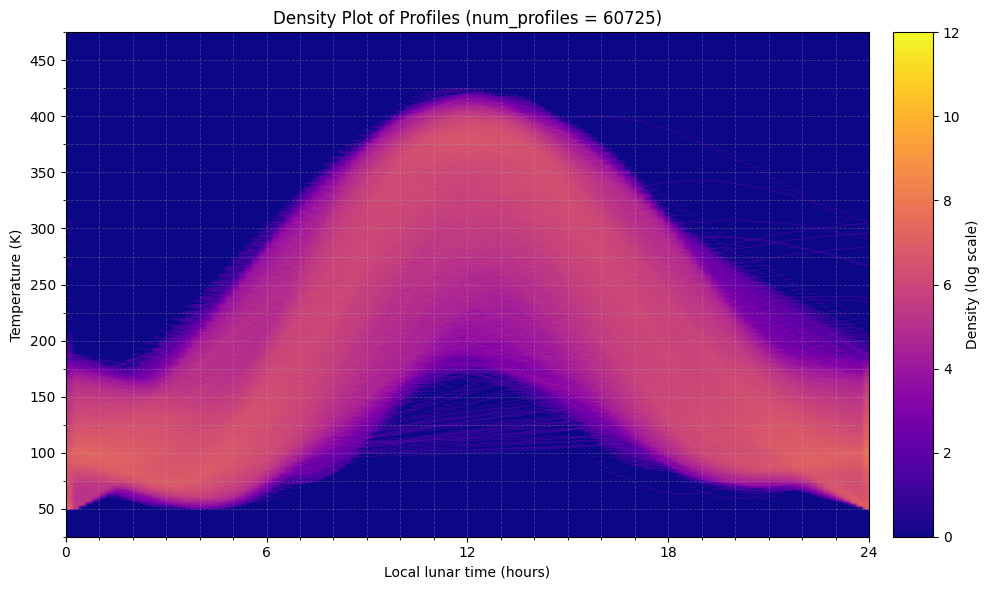

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 197.0157
STD: 96.1638
Min Temp: 50.0020
Max Temp: 424.6720
Datasets:
Training Data: 42507
Validation Data: 12145
Test Data: 6073


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 213/213 [00:07<00:00, 27.47it/s, best_loss=0.8637]


[Training] Epoch 1/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0072, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 61/61 [00:00<00:00, 93.60it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0003
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_25-5d_20250805_0142'


[Training] Epoch 2/100: 100%|██████████| 213/213 [00:07<00:00, 27.48it/s, best_loss=0.9033]


[Training] Epoch 2/100, L1 Loss: 0.8166, L2 Loss: 0.9998, KL Loss: 0.0004, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 61/61 [00:00<00:00, 94.69it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 3/100: 100%|██████████| 213/213 [00:07<00:00, 26.84it/s, best_loss=0.8768]


[Training] Epoch 3/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 61/61 [00:00<00:00, 95.03it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 4/100: 100%|██████████| 213/213 [00:07<00:00, 27.33it/s, best_loss=0.8937]


[Training] Epoch 4/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 61/61 [00:00<00:00, 91.10it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 5/100: 100%|██████████| 213/213 [00:07<00:00, 26.95it/s, best_loss=0.8940]


[Training] Epoch 5/100, L1 Loss: 0.8167, L2 Loss: 1.0002, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 61/61 [00:00<00:00, 90.41it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 6/100: 100%|██████████| 213/213 [00:07<00:00, 27.74it/s, best_loss=0.9170]


[Training] Epoch 6/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 61/61 [00:00<00:00, 90.96it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 7/100: 100%|██████████| 213/213 [00:07<00:00, 27.42it/s, best_loss=0.8897]


[Training] Epoch 7/100, L1 Loss: 0.8166, L2 Loss: 0.9998, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 61/61 [00:00<00:00, 91.85it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 8/100: 100%|██████████| 213/213 [00:07<00:00, 27.54it/s, best_loss=0.8843]


[Training] Epoch 8/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 61/61 [00:00<00:00, 90.31it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 9/100: 100%|██████████| 213/213 [00:07<00:00, 27.43it/s, best_loss=0.8872]


[Training] Epoch 9/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 61/61 [00:00<00:00, 93.00it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 10/100: 100%|██████████| 213/213 [00:07<00:00, 27.12it/s, best_loss=0.9056]


[Training] Epoch 10/100, L1 Loss: 0.8167, L2 Loss: 1.0002, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 61/61 [00:00<00:00, 91.10it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 11/100: 100%|██████████| 213/213 [00:07<00:00, 27.13it/s, best_loss=0.8803]


[Training] Epoch 11/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 61/61 [00:00<00:00, 96.13it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 12/100: 100%|██████████| 213/213 [00:07<00:00, 27.52it/s, best_loss=0.9059]


[Training] Epoch 12/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 61/61 [00:00<00:00, 91.66it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 13/100: 100%|██████████| 213/213 [00:07<00:00, 27.86it/s, best_loss=0.8815]


[Training] Epoch 13/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 61/61 [00:00<00:00, 94.79it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 14/100: 100%|██████████| 213/213 [00:07<00:00, 27.78it/s, best_loss=0.8666]


[Training] Epoch 14/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 61/61 [00:00<00:00, 97.09it/s] 


[Validation] Epoch 14/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 15/100: 100%|██████████| 213/213 [00:07<00:00, 27.52it/s, best_loss=0.8406]


[Training] Epoch 15/100, L1 Loss: 0.8168, L2 Loss: 1.0002, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 61/61 [00:00<00:00, 84.56it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 16/100: 100%|██████████| 213/213 [00:07<00:00, 27.53it/s, best_loss=0.8819]


[Training] Epoch 16/100, L1 Loss: 0.8167, L2 Loss: 1.0002, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 61/61 [00:00<00:00, 92.13it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 17/100: 100%|██████████| 213/213 [00:07<00:00, 27.41it/s, best_loss=0.8908]


[Training] Epoch 17/100, L1 Loss: 0.8168, L2 Loss: 1.0002, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 61/61 [00:00<00:00, 88.64it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 18/100: 100%|██████████| 213/213 [00:07<00:00, 26.93it/s, best_loss=0.9104]


[Training] Epoch 18/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 61/61 [00:00<00:00, 93.37it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 19/100: 100%|██████████| 213/213 [00:07<00:00, 27.44it/s, best_loss=0.8833]


[Training] Epoch 19/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 61/61 [00:00<00:00, 81.97it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 20/100: 100%|██████████| 213/213 [00:07<00:00, 27.53it/s, best_loss=0.8853]


[Training] Epoch 20/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 61/61 [00:00<00:00, 89.18it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 21/100: 100%|██████████| 213/213 [00:07<00:00, 27.44it/s, best_loss=0.9046]


[Training] Epoch 21/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 61/61 [00:00<00:00, 91.32it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 22/100: 100%|██████████| 213/213 [00:07<00:00, 27.51it/s, best_loss=0.8718]


[Training] Epoch 22/100, L1 Loss: 0.8166, L2 Loss: 0.9997, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 61/61 [00:00<00:00, 91.94it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0003


[Training] Epoch 23/100: 100%|██████████| 213/213 [00:07<00:00, 27.71it/s, best_loss=0.8816]


[Training] Epoch 23/100, L1 Loss: 0.8166, L2 Loss: 0.9998, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 61/61 [00:00<00:00, 94.09it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 24/100: 100%|██████████| 213/213 [00:07<00:00, 27.18it/s, best_loss=0.9019]


[Training] Epoch 24/100, L1 Loss: 0.8166, L2 Loss: 0.9998, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 61/61 [00:00<00:00, 89.69it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 25/100: 100%|██████████| 213/213 [00:07<00:00, 28.60it/s, best_loss=0.8515]


[Training] Epoch 25/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 61/61 [00:00<00:00, 103.10it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 26/100: 100%|██████████| 213/213 [00:06<00:00, 31.35it/s, best_loss=0.8804]


[Training] Epoch 26/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 61/61 [00:00<00:00, 105.89it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 27/100: 100%|██████████| 213/213 [00:06<00:00, 31.66it/s, best_loss=0.8852]


[Training] Epoch 27/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 61/61 [00:00<00:00, 105.34it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 28/100: 100%|██████████| 213/213 [00:06<00:00, 30.89it/s, best_loss=0.8844]


[Training] Epoch 28/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 61/61 [00:00<00:00, 102.08it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 29/100: 100%|██████████| 213/213 [00:06<00:00, 31.11it/s, best_loss=0.8866]


[Training] Epoch 29/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 61/61 [00:00<00:00, 100.17it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 30/100: 100%|██████████| 213/213 [00:06<00:00, 31.13it/s, best_loss=0.8975]


[Training] Epoch 30/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 61/61 [00:00<00:00, 105.97it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 31/100: 100%|██████████| 213/213 [00:06<00:00, 31.12it/s, best_loss=0.8907]


[Training] Epoch 31/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 61/61 [00:00<00:00, 96.99it/s] 


[Validation] Epoch 31/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 32/100: 100%|██████████| 213/213 [00:06<00:00, 31.61it/s, best_loss=0.8714]


[Training] Epoch 32/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 61/61 [00:00<00:00, 103.42it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 33/100: 100%|██████████| 213/213 [00:06<00:00, 30.95it/s, best_loss=0.8855]


[Training] Epoch 33/100, L1 Loss: 0.8168, L2 Loss: 1.0003, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 61/61 [00:00<00:00, 101.35it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 34/100: 100%|██████████| 213/213 [00:07<00:00, 30.37it/s, best_loss=0.8849]


[Training] Epoch 34/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 61/61 [00:00<00:00, 105.98it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 35/100: 100%|██████████| 213/213 [00:06<00:00, 31.45it/s, best_loss=0.8973]


[Training] Epoch 35/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 61/61 [00:00<00:00, 105.01it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 36/100: 100%|██████████| 213/213 [00:06<00:00, 31.65it/s, best_loss=0.8889]


[Training] Epoch 36/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 61/61 [00:00<00:00, 105.89it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 37/100: 100%|██████████| 213/213 [00:06<00:00, 31.18it/s, best_loss=0.8903]


[Training] Epoch 37/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 61/61 [00:00<00:00, 101.39it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 38/100: 100%|██████████| 213/213 [00:06<00:00, 31.27it/s, best_loss=0.9079]


[Training] Epoch 38/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 61/61 [00:00<00:00, 100.18it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 39/100: 100%|██████████| 213/213 [00:06<00:00, 30.95it/s, best_loss=0.8758]


[Training] Epoch 39/100, L1 Loss: 0.8166, L2 Loss: 0.9998, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 61/61 [00:00<00:00, 106.23it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 40/100: 100%|██████████| 213/213 [00:06<00:00, 31.12it/s, best_loss=0.8761]


[Training] Epoch 40/100, L1 Loss: 0.8168, L2 Loss: 1.0002, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 61/61 [00:00<00:00, 101.46it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 41/100: 100%|██████████| 213/213 [00:07<00:00, 28.85it/s, best_loss=0.8959]


[Training] Epoch 41/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 61/61 [00:00<00:00, 87.02it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 42/100: 100%|██████████| 213/213 [00:07<00:00, 27.09it/s, best_loss=0.8652]


[Training] Epoch 42/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 61/61 [00:00<00:00, 95.40it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 43/100: 100%|██████████| 213/213 [00:07<00:00, 27.24it/s, best_loss=0.9071]


[Training] Epoch 43/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 61/61 [00:00<00:00, 82.59it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 44/100: 100%|██████████| 213/213 [00:07<00:00, 27.53it/s, best_loss=0.9029]


[Training] Epoch 44/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 61/61 [00:00<00:00, 90.21it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 45/100: 100%|██████████| 213/213 [00:07<00:00, 27.24it/s, best_loss=0.8901]


[Training] Epoch 45/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 61/61 [00:00<00:00, 87.69it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 46/100: 100%|██████████| 213/213 [00:07<00:00, 27.49it/s, best_loss=0.8759]


[Training] Epoch 46/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 61/61 [00:00<00:00, 94.81it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 47/100: 100%|██████████| 213/213 [00:07<00:00, 27.29it/s, best_loss=0.8939]


[Training] Epoch 47/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 61/61 [00:00<00:00, 89.49it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 48/100: 100%|██████████| 213/213 [00:07<00:00, 26.91it/s, best_loss=0.9049]


[Training] Epoch 48/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 61/61 [00:00<00:00, 88.07it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 49/100: 100%|██████████| 213/213 [00:08<00:00, 26.39it/s, best_loss=0.8684]


[Training] Epoch 49/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 61/61 [00:00<00:00, 92.41it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 50/100: 100%|██████████| 213/213 [00:07<00:00, 27.61it/s, best_loss=0.8958]


[Training] Epoch 50/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 61/61 [00:00<00:00, 90.76it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 51/100: 100%|██████████| 213/213 [00:07<00:00, 27.50it/s, best_loss=0.8901]


[Training] Epoch 51/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 61/61 [00:00<00:00, 95.95it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 52/100: 100%|██████████| 213/213 [00:07<00:00, 27.69it/s, best_loss=0.8805]


[Training] Epoch 52/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 61/61 [00:00<00:00, 96.90it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 53/100: 100%|██████████| 213/213 [00:07<00:00, 26.91it/s, best_loss=0.8699]


[Training] Epoch 53/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 61/61 [00:00<00:00, 86.99it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 54/100: 100%|██████████| 213/213 [00:07<00:00, 27.45it/s, best_loss=0.8575]


[Training] Epoch 54/100, L1 Loss: 0.8167, L2 Loss: 1.0002, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 61/61 [00:00<00:00, 92.35it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 55/100: 100%|██████████| 213/213 [00:07<00:00, 27.20it/s, best_loss=0.8683]


[Training] Epoch 55/100, L1 Loss: 0.8166, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 61/61 [00:00<00:00, 93.39it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 56/100: 100%|██████████| 213/213 [00:07<00:00, 27.09it/s, best_loss=0.8541]


[Training] Epoch 56/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 61/61 [00:00<00:00, 91.12it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 57/100: 100%|██████████| 213/213 [00:07<00:00, 26.80it/s, best_loss=0.8997]


[Training] Epoch 57/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 61/61 [00:00<00:00, 92.53it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 58/100: 100%|██████████| 213/213 [00:08<00:00, 26.58it/s, best_loss=0.8994]


[Training] Epoch 58/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 61/61 [00:00<00:00, 90.58it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 59/100: 100%|██████████| 213/213 [00:07<00:00, 27.35it/s, best_loss=0.8901]


[Training] Epoch 59/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 61/61 [00:00<00:00, 95.84it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 60/100: 100%|██████████| 213/213 [00:07<00:00, 27.35it/s, best_loss=0.9097]


[Training] Epoch 60/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 61/61 [00:00<00:00, 90.77it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 61/100: 100%|██████████| 213/213 [00:07<00:00, 27.48it/s, best_loss=0.9050]


[Training] Epoch 61/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 61/61 [00:00<00:00, 95.58it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 62/100: 100%|██████████| 213/213 [00:07<00:00, 27.57it/s, best_loss=0.8987]


[Training] Epoch 62/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 61/61 [00:00<00:00, 78.33it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 63/100: 100%|██████████| 213/213 [00:07<00:00, 27.42it/s, best_loss=0.8832]


[Training] Epoch 63/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 61/61 [00:00<00:00, 92.86it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 64/100: 100%|██████████| 213/213 [00:07<00:00, 27.00it/s, best_loss=0.8930]


[Training] Epoch 64/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 61/61 [00:00<00:00, 86.90it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 65/100: 100%|██████████| 213/213 [00:07<00:00, 27.07it/s, best_loss=0.8749]


[Training] Epoch 65/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 61/61 [00:00<00:00, 92.27it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 66/100: 100%|██████████| 213/213 [00:07<00:00, 27.35it/s, best_loss=0.8801]


[Training] Epoch 66/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 61/61 [00:00<00:00, 90.96it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 67/100: 100%|██████████| 213/213 [00:07<00:00, 27.52it/s, best_loss=0.9067]


[Training] Epoch 67/100, L1 Loss: 0.8166, L2 Loss: 0.9998, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 61/61 [00:00<00:00, 91.51it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 68/100: 100%|██████████| 213/213 [00:07<00:00, 27.38it/s, best_loss=0.8784]


[Training] Epoch 68/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 61/61 [00:00<00:00, 91.11it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 69/100: 100%|██████████| 213/213 [00:07<00:00, 27.21it/s, best_loss=0.9101]


[Training] Epoch 69/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 61/61 [00:00<00:00, 91.65it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 70/100: 100%|██████████| 213/213 [00:07<00:00, 27.42it/s, best_loss=0.8718]


[Training] Epoch 70/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 61/61 [00:00<00:00, 94.17it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 71/100: 100%|██████████| 213/213 [00:07<00:00, 27.40it/s, best_loss=0.8957]


[Training] Epoch 71/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 61/61 [00:00<00:00, 90.06it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 72/100: 100%|██████████| 213/213 [00:07<00:00, 26.99it/s, best_loss=0.8837]


[Training] Epoch 72/100, L1 Loss: 0.8166, L2 Loss: 0.9998, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 61/61 [00:00<00:00, 89.44it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 73/100: 100%|██████████| 213/213 [00:07<00:00, 27.24it/s, best_loss=0.8901]


[Training] Epoch 73/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 61/61 [00:00<00:00, 91.69it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 74/100: 100%|██████████| 213/213 [00:07<00:00, 26.88it/s, best_loss=0.8772]


[Training] Epoch 74/100, L1 Loss: 0.8168, L2 Loss: 1.0002, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 61/61 [00:00<00:00, 88.73it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 75/100: 100%|██████████| 213/213 [00:07<00:00, 27.38it/s, best_loss=0.9060]


[Training] Epoch 75/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 61/61 [00:00<00:00, 91.37it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 76/100: 100%|██████████| 213/213 [00:07<00:00, 27.47it/s, best_loss=0.8836]


[Training] Epoch 76/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 61/61 [00:00<00:00, 89.37it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 77/100: 100%|██████████| 213/213 [00:07<00:00, 27.12it/s, best_loss=0.8984]


[Training] Epoch 77/100, L1 Loss: 0.8168, L2 Loss: 1.0002, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 61/61 [00:00<00:00, 91.44it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 78/100: 100%|██████████| 213/213 [00:07<00:00, 27.11it/s, best_loss=0.8665]


[Training] Epoch 78/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 61/61 [00:00<00:00, 87.02it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 79/100: 100%|██████████| 213/213 [00:07<00:00, 27.02it/s, best_loss=0.8978]


[Training] Epoch 79/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 61/61 [00:00<00:00, 88.97it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 80/100: 100%|██████████| 213/213 [00:07<00:00, 27.30it/s, best_loss=0.8825]


[Training] Epoch 80/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 61/61 [00:00<00:00, 87.20it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 81/100: 100%|██████████| 213/213 [00:07<00:00, 27.63it/s, best_loss=0.8706]


[Training] Epoch 81/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 61/61 [00:00<00:00, 76.10it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 82/100: 100%|██████████| 213/213 [00:07<00:00, 27.29it/s, best_loss=0.9095]


[Training] Epoch 82/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 61/61 [00:00<00:00, 91.20it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 83/100: 100%|██████████| 213/213 [00:07<00:00, 27.23it/s, best_loss=0.8726]


[Training] Epoch 83/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 61/61 [00:00<00:00, 88.91it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 84/100: 100%|██████████| 213/213 [00:07<00:00, 27.09it/s, best_loss=0.8710]


[Training] Epoch 84/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 61/61 [00:00<00:00, 88.90it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 85/100: 100%|██████████| 213/213 [00:07<00:00, 27.05it/s, best_loss=0.8811]


[Training] Epoch 85/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 61/61 [00:00<00:00, 88.55it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 86/100: 100%|██████████| 213/213 [00:08<00:00, 26.51it/s, best_loss=0.8774]


[Training] Epoch 86/100, L1 Loss: 0.8166, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 61/61 [00:00<00:00, 91.96it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 87/100: 100%|██████████| 213/213 [00:07<00:00, 27.18it/s, best_loss=0.9154]


[Training] Epoch 87/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 61/61 [00:00<00:00, 91.85it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 88/100: 100%|██████████| 213/213 [00:07<00:00, 27.30it/s, best_loss=0.8661]


[Training] Epoch 88/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 61/61 [00:00<00:00, 88.41it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 89/100: 100%|██████████| 213/213 [00:07<00:00, 27.20it/s, best_loss=0.8619]


[Training] Epoch 89/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 61/61 [00:00<00:00, 93.41it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 90/100: 100%|██████████| 213/213 [00:07<00:00, 27.50it/s, best_loss=0.9029]


[Training] Epoch 90/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 61/61 [00:00<00:00, 90.66it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 91/100: 100%|██████████| 213/213 [00:07<00:00, 27.37it/s, best_loss=0.8765]


[Training] Epoch 91/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 61/61 [00:00<00:00, 89.07it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 92/100: 100%|██████████| 213/213 [00:07<00:00, 27.38it/s, best_loss=0.8847]


[Training] Epoch 92/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 61/61 [00:00<00:00, 90.47it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 93/100: 100%|██████████| 213/213 [00:07<00:00, 27.33it/s, best_loss=0.8775]


[Training] Epoch 93/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 61/61 [00:00<00:00, 90.84it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 94/100: 100%|██████████| 213/213 [00:07<00:00, 26.92it/s, best_loss=0.9016]


[Training] Epoch 94/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 61/61 [00:00<00:00, 90.16it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 95/100: 100%|██████████| 213/213 [00:07<00:00, 26.89it/s, best_loss=0.9066]


[Training] Epoch 95/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 61/61 [00:00<00:00, 89.35it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 96/100: 100%|██████████| 213/213 [00:07<00:00, 26.80it/s, best_loss=0.8814]


[Training] Epoch 96/100, L1 Loss: 0.8167, L2 Loss: 1.0002, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 61/61 [00:00<00:00, 87.48it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 97/100: 100%|██████████| 213/213 [00:07<00:00, 27.14it/s, best_loss=0.9084]


[Training] Epoch 97/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 61/61 [00:00<00:00, 92.48it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 98/100: 100%|██████████| 213/213 [00:07<00:00, 27.33it/s, best_loss=0.8909]


[Training] Epoch 98/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 61/61 [00:00<00:00, 90.88it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 99/100: 100%|██████████| 213/213 [00:07<00:00, 27.08it/s, best_loss=0.8823]


[Training] Epoch 99/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 61/61 [00:00<00:00, 89.24it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


[Training] Epoch 100/100: 100%|██████████| 213/213 [00:07<00:00, 26.65it/s, best_loss=0.8877]


[Training] Epoch 100/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0003, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 61/61 [00:00<00:00, 83.35it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.8177, Val L2 Loss: 1.0025, Val KL Loss: 0.0002


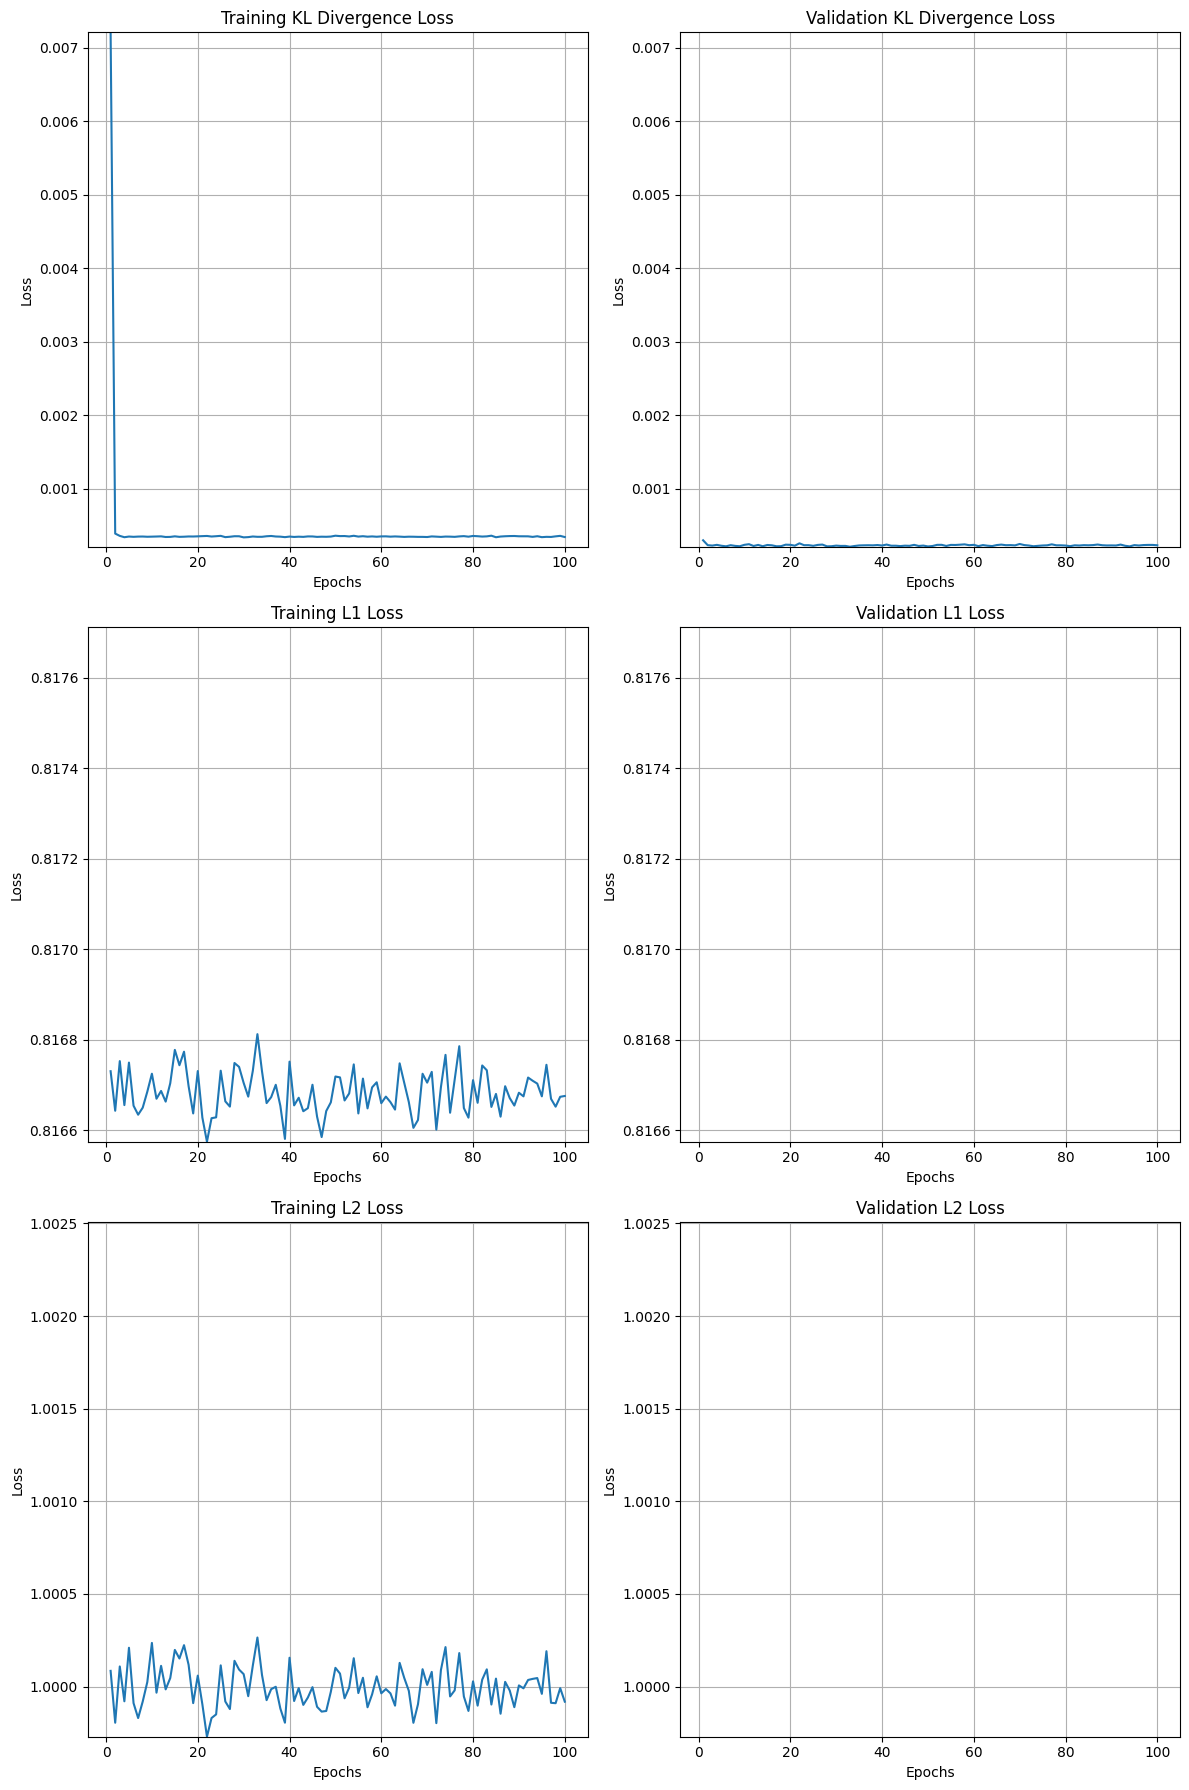

Best Validation Loss in Kelvins:
78.6343 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


z0: -0.0005
z1: 0.0006
z2: -0.0009
z3: 0.0006


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 613.59it/s]


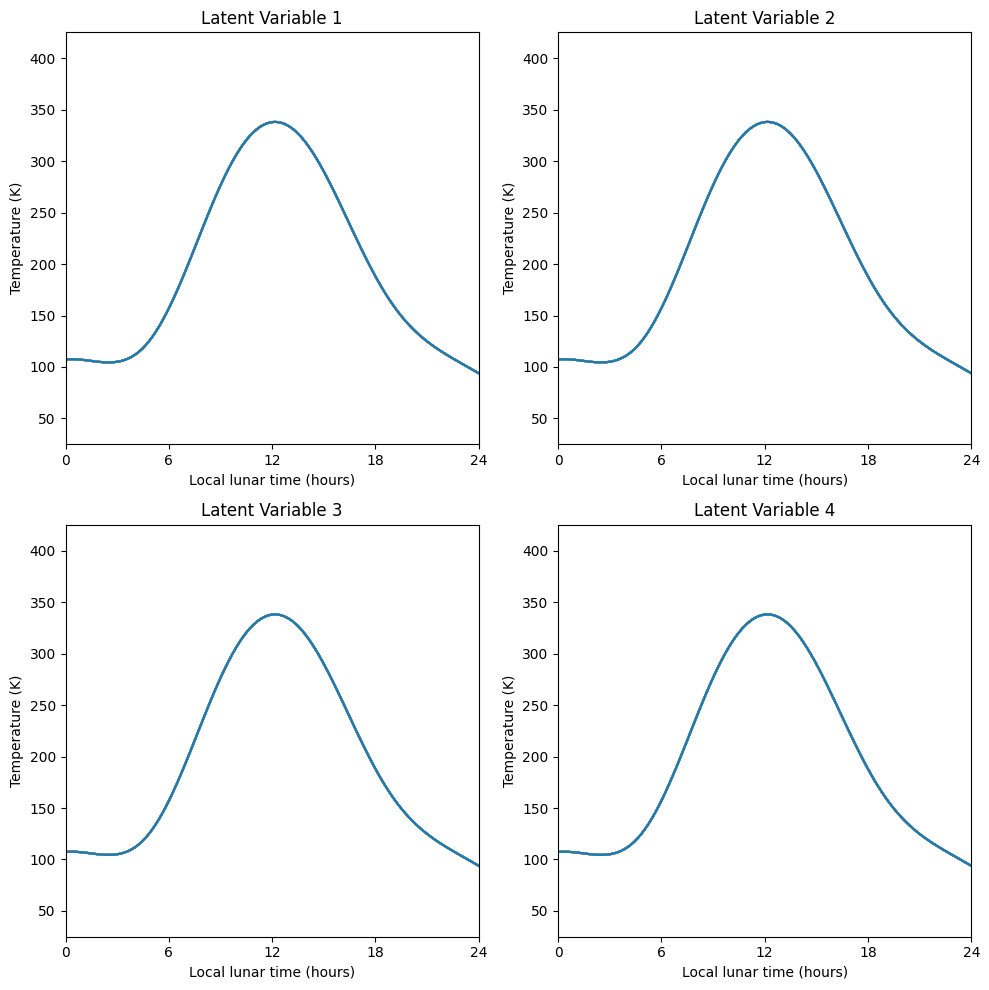

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)